In [1]:
print('hello world')

hello world


In [2]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

from datasets_code import build_dataloader, build_dataset
from utils.options import parse_options
from train import create_train_val_dataloader
import torch
import numpy as np

import os
os.chdir('/home/s94zalek/shape_matching')

# print current working directory
print(os.getcwd())

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
/home/s94zalek/shape_matching


In [3]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False,
                    opt_path = 'options/train/faust.yaml')

opt['root_path'] = root_path
opt['dist'] = False

opt['datasets']['train_dataset']['return_corr'] = True
opt['datasets']['train_dataset']['return_dist'] = False
opt['datasets']['test_dataset']['return_dist'] = False

# create train and validation dataloaders
result = create_train_val_dataloader(opt)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])


Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240423_084811


Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 96.16it/s]
/home/s94zalek/.conda/envs/fmnet/lib/python3.8/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Calculating functional maps: 100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 97.24it/s]


In [4]:
from tqdm import tqdm

# data_x = test_set[15]['first']
# data_y = test_set[15]['second']

# get 15th element from test dataloader
for i, data in enumerate(tqdm(test_loader)):
    if i == 10:
        data_pair = data
        data_x = data['first']
        data_y = data['second']
        break

print('data_pair.keys()', list(data_pair.keys()))
print('data_x.keys()', list(data_x.keys()))

  2%|██▋                                                                                                         | 10/400 [00:01<00:54,  7.21it/s]

data_pair.keys() ['first', 'second', 'Cxy', 'Cyx']
data_x.keys() ['name', 'verts', 'faces', 'evecs', 'evecs_trans', 'evals', 'mass', 'L', 'corr']


In [5]:
data_pair['Cxy'].shape

torch.Size([1, 200, 200])

Cxy.shape torch.Size([200, 200])
AbsErr(Cxy @ Cxy_T, I), sum: 419.2453, mean: 0.0105
AbsErr(Cxy_T @ Cxy, I), sum: 461.2935, mean: 0.0115
AbsErr(Cyx @ Cyx_T, I), sum: 458.4039, mean: 0.0115
AbsErr(Cxy @ Cyx, I), sum: 230.7171, mean: 0.0058
AbsErr(Cyx @ Cxy, I), sum: 238.7559, mean: 0.0060


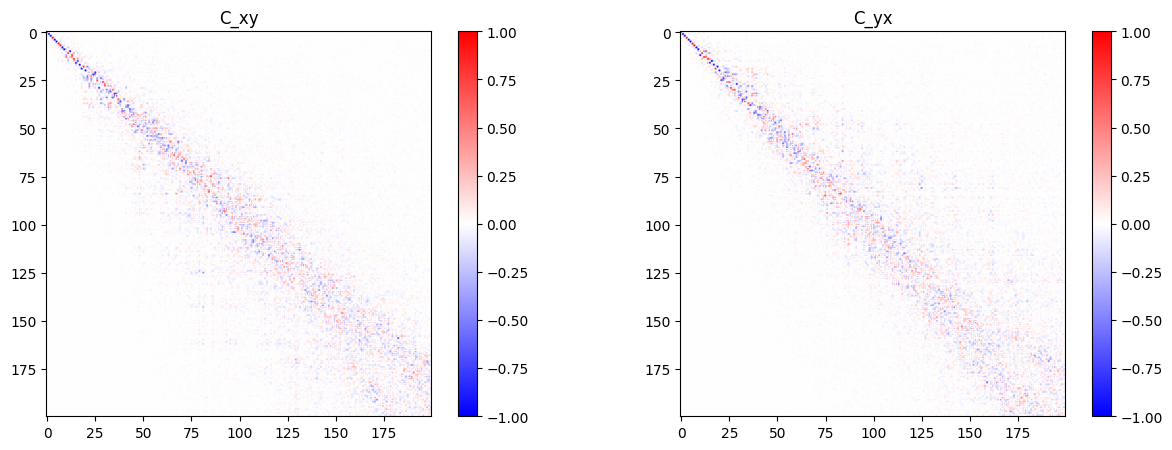

In [6]:
# plot Cxy and Cyx
import matplotlib.pyplot as plt

C_gt_xy = data_pair['Cxy'][0]
C_gt_yx = data_pair['Cyx'][0]


print('Cxy.shape', C_gt_xy.shape)

# check orthogonality for C_gt_xy and C_gt_yx
val = (C_gt_xy @ C_gt_xy.T - torch.eye(C_gt_xy.shape[0])).abs()
print(f'AbsErr(Cxy @ Cxy_T, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_xy.T @ C_gt_xy - torch.eye(C_gt_xy.shape[0])).abs()
print(f'AbsErr(Cxy_T @ Cxy, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_yx @ C_gt_yx.T - torch.eye(C_gt_yx.shape[0])).abs()
print(f'AbsErr(Cyx @ Cyx_T, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_xy @ C_gt_yx - torch.eye(C_gt_xy.shape[0])).abs()
print(f'AbsErr(Cxy @ Cyx, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

val = (C_gt_yx @ C_gt_xy - torch.eye(C_gt_yx.shape[0])).abs()
print(f'AbsErr(Cyx @ Cxy, I), sum: {val.sum().item():.4f}, mean: {val.mean().item():.4f}')

# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# C_gt_xy
C_gt_xy_plot = ax[0].imshow(C_gt_xy.cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(C_gt_xy_plot)
# ax[0].axis('off')
# ax[0].set_title('C_xy pinv')
ax[0].set_title('C_xy')

# C_gt_yx
C_gt_yx_plot = ax[1].imshow(C_gt_yx.cpu().numpy(), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar(C_gt_yx_plot)
# ax[1].axis('off')
# ax[1].set_title('C_yx pinv')
ax[1].set_title('C_yx')

plt.show()

# Visualization of Cxy for one shape

In [25]:
names_y = []
Cxy_tr_reg_040 = []
Cyx_tr_reg_040 = []

train_dataset = train_loader.dataset
print(len(train_dataset))
for i in tqdm(range(len(train_dataset))):
    data = train_dataset[i]
    if data['first']['name'] == 'tr_reg_040':
        Cxy_tr_reg_040.append(data['Cxy'])
        Cyx_tr_reg_040.append(data['Cyx'])
        names_y.append(data['second']['name'])

Cxy_tr_reg_040_full = torch.stack(Cxy_tr_reg_040)
Cyx_tr_reg_040_full = torch.stack(Cyx_tr_reg_040)
    
Cxy_tr_reg_040 = torch.stack(Cxy_tr_reg_040)[:, :20, :20]
Cyx_tr_reg_040 = torch.stack(Cyx_tr_reg_040)[:, :20, :20]
    
print(Cxy_tr_reg_040.shape)
print(Cyx_tr_reg_040.shape)
print(names_y)

6400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 6400/6400 [00:00<00:00, 592546.59it/s]

torch.Size([80, 20, 20])
torch.Size([80, 20, 20])
['tr_reg_000', 'tr_reg_001', 'tr_reg_002', 'tr_reg_003', 'tr_reg_004', 'tr_reg_005', 'tr_reg_006', 'tr_reg_007', 'tr_reg_008', 'tr_reg_009', 'tr_reg_010', 'tr_reg_011', 'tr_reg_012', 'tr_reg_013', 'tr_reg_014', 'tr_reg_015', 'tr_reg_016', 'tr_reg_017', 'tr_reg_018', 'tr_reg_019', 'tr_reg_020', 'tr_reg_021', 'tr_reg_022', 'tr_reg_023', 'tr_reg_024', 'tr_reg_025', 'tr_reg_026', 'tr_reg_027', 'tr_reg_028', 'tr_reg_029', 'tr_reg_030', 'tr_reg_031', 'tr_reg_032', 'tr_reg_033', 'tr_reg_034', 'tr_reg_035', 'tr_reg_036', 'tr_reg_037', 'tr_reg_038', 'tr_reg_039', 'tr_reg_040', 'tr_reg_041', 'tr_reg_042', 'tr_reg_043', 'tr_reg_044', 'tr_reg_045', 'tr_reg_046', 'tr_reg_047', 'tr_reg_048', 'tr_reg_049', 'tr_reg_050', 'tr_reg_051', 'tr_reg_052', 'tr_reg_053', 'tr_reg_054', 'tr_reg_055', 'tr_reg_056', 'tr_reg_057', 'tr_reg_058', 'tr_reg_059', 'tr_reg_060', 'tr_reg_061', 'tr_reg_062', 'tr_reg_063', 'tr_reg_064', 'tr_reg_065', 'tr_reg_066', 'tr_reg_067

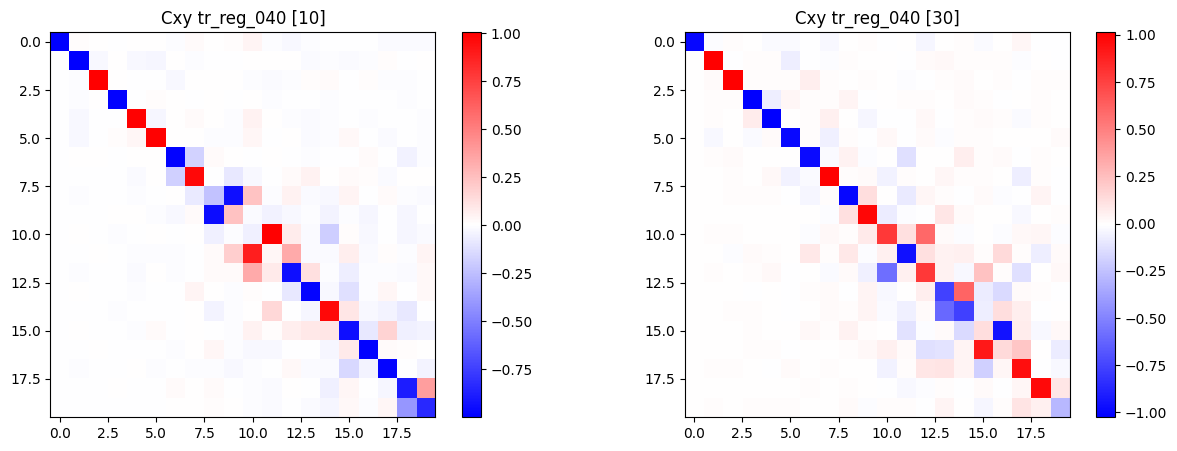

In [8]:
# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# C_gt_xy
C_gt_xy_plot = ax[0].imshow((Cxy_tr_reg_040[10][:20, :20]).cpu().numpy(), cmap='bwr')
plt.colorbar(C_gt_xy_plot)
# ax[0].axis('off')
# ax[0].set_title('C_xy pinv')
ax[0].set_title('Cxy tr_reg_040 [10]')

# C_gt_yx
C_gt_yx_plot = ax[1].imshow((Cxy_tr_reg_040[30][:20, :20]).cpu().numpy(), cmap='bwr')
plt.colorbar(C_gt_yx_plot)
# ax[1].axis('off')
# ax[1].set_title('C_yx pinv')
ax[1].set_title('Cxy tr_reg_040 [30]')

plt.show()

torch.Size([200, 200])


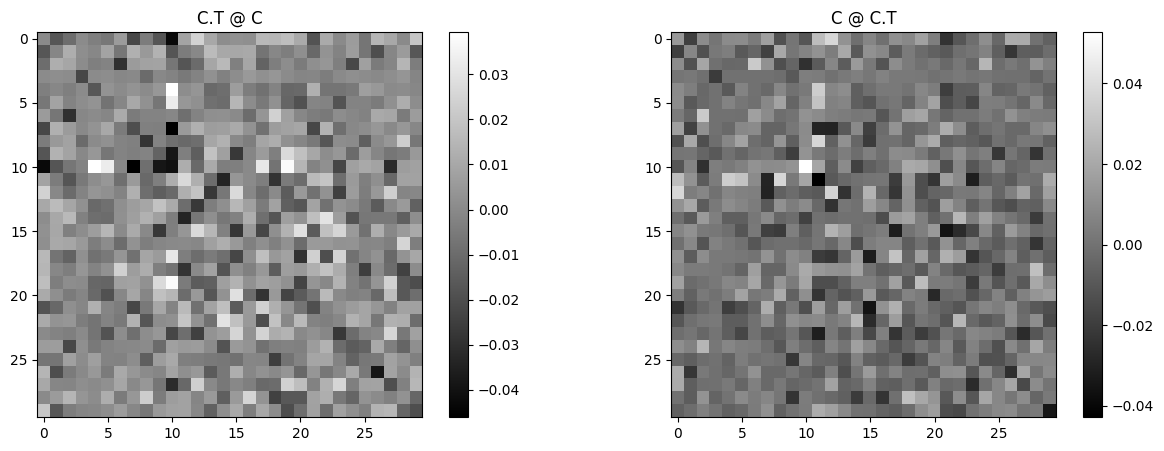

In [9]:
# plot them
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

Cxy_40_10 = Cxy_tr_reg_040_full[10]
print(Cxy_40_10.shape)
Cxy_40_10_T_Cxy_40_10 = (Cxy_40_10.T @ Cxy_40_10)[:30, :30]
Cxy_40_10_Cxy_40_10_T = (Cxy_40_10 @ Cxy_40_10.T)[:30, :30]

# C_gt_xy
Cxy_40_10_T_Cxy_40_10_plot = ax[0].imshow(Cxy_40_10_T_Cxy_40_10.cpu().numpy() - np.eye(30),
                                     cmap='gray')
plt.colorbar(Cxy_40_10_T_Cxy_40_10_plot)
# ax[0].axis('off')
# ax[0].set_title('C_xy pinv')
ax[0].set_title('C.T @ C')

# C_gt_yx
Cxy_40_10_Cxy_40_10_T_plot = ax[1].imshow(Cxy_40_10_Cxy_40_10_T.cpu().numpy() - np.eye(30), cmap='gray')
plt.colorbar(Cxy_40_10_Cxy_40_10_T_plot)
# ax[1].axis('off')
# ax[1].set_title('C_yx pinv')
ax[1].set_title('C @ C.T')

plt.show()

In [10]:
Cxy_T_Cxy_040 = torch.bmm(Cxy_tr_reg_040_full.transpose(1, 2), Cxy_tr_reg_040_full)
n_10 = Cxy_T_Cxy_040[10][:30, :30]
print((Cxy_40_10_T_Cxy_40_10 - n_10).abs().sum())

tensor(0.)


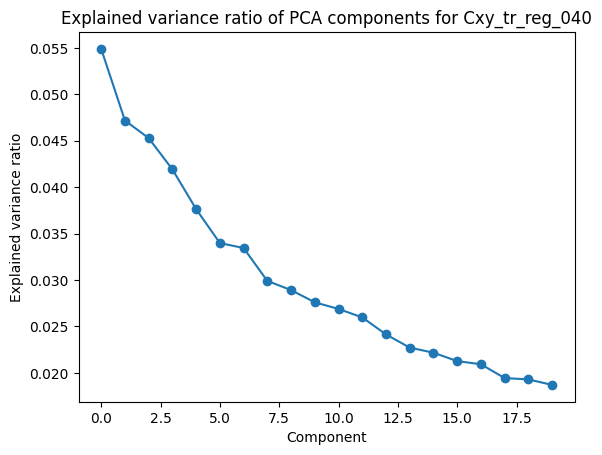

In [11]:
# apply PCA to Cxy_tr_reg_040
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=20)
scaler = StandardScaler()

Cxy_tr_reg_040_scaled = scaler.fit_transform(
    Cxy_tr_reg_040.cpu().numpy().reshape(-1, 400)
    )

Cxy_tr_reg_040_pca = pca.fit_transform(
    Cxy_tr_reg_040_scaled
    )

plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_tr_reg_040')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

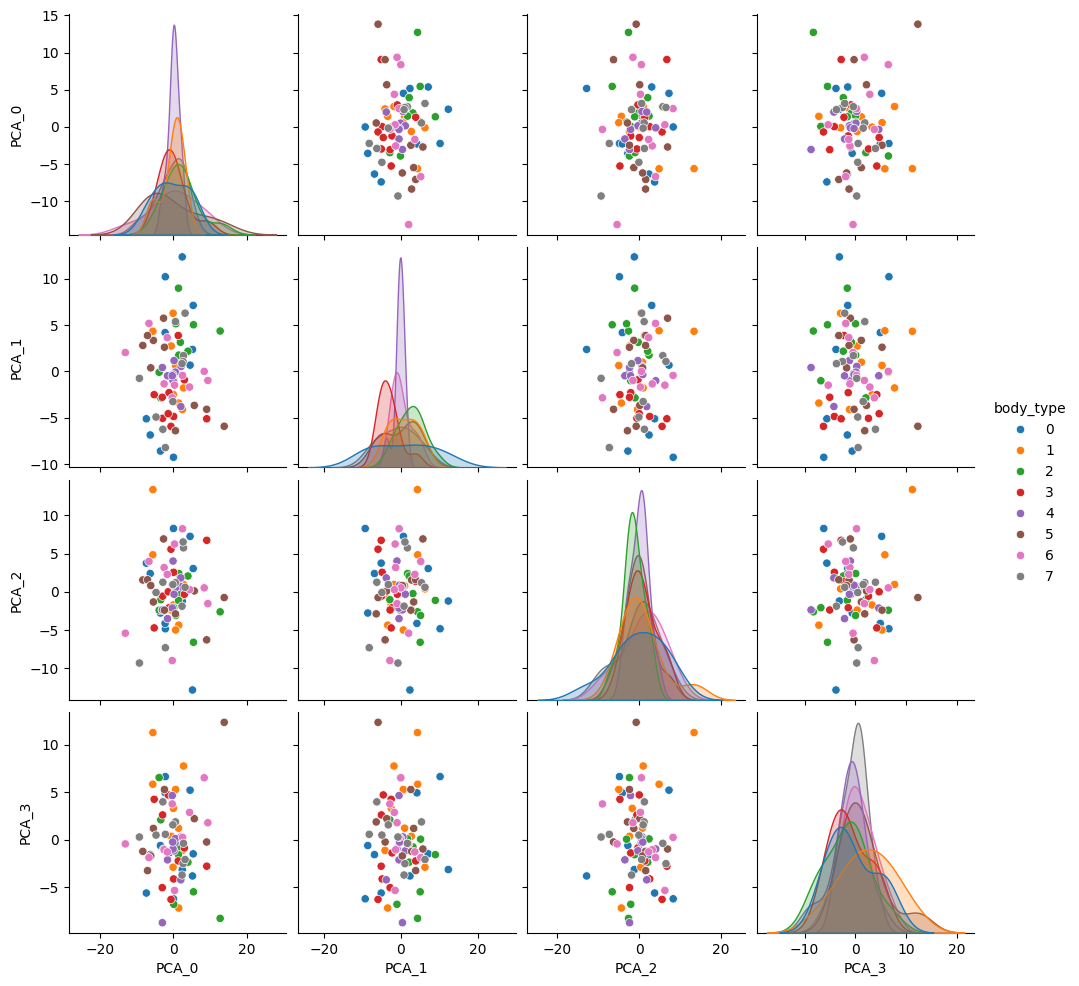

In [48]:
# plot the first 6 principal components
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(Cxy_tr_reg_040_pca[:, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(80)]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10'
             )
plt.show()

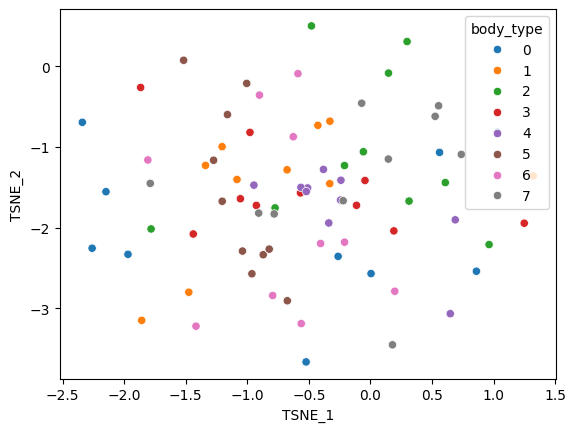

In [49]:
# repeat with T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
scaler = StandardScaler()

Cxy_tr_reg_040_scaled = scaler.fit_transform(
    Cxy_tr_reg_040.cpu().numpy().reshape(-1, 400)
    )

Cxy_tr_reg_040_tsne = tsne.fit_transform(
    Cxy_tr_reg_040_scaled
    )

pca_df = pd.DataFrame(Cxy_tr_reg_040_tsne, columns=['TSNE_1', 'TSNE_2'])
pca_df['name'] = names_y[:80]
pca_df['body_type'] = [i // 10 for i in range(80)]

sns.scatterplot(data=pca_df, x='TSNE_1', y='TSNE_2', hue='body_type', palette='tab10')
plt.show()


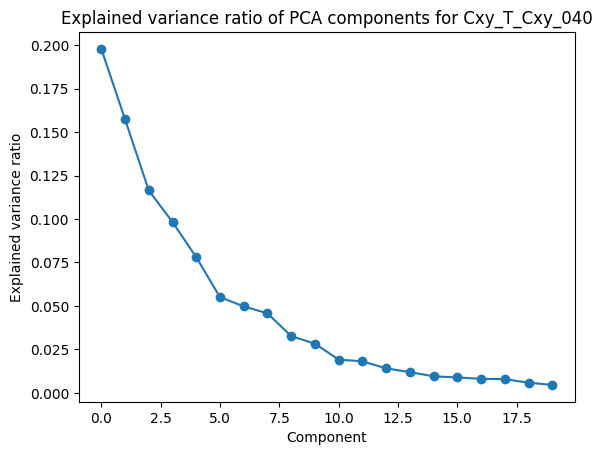

In [13]:
# apply PCA to Cxy_tr_reg_040
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=20)

scaler = StandardScaler()

Cxy_T_Cxy_040_scaled = scaler.fit_transform(Cxy_T_Cxy_040[:, :20, :20].cpu().numpy().reshape(-1, 400))

Cxy_T_Cxy_040_pca = pca.fit_transform(
    Cxy_T_Cxy_040_scaled
    )


plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_T_Cxy_040')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

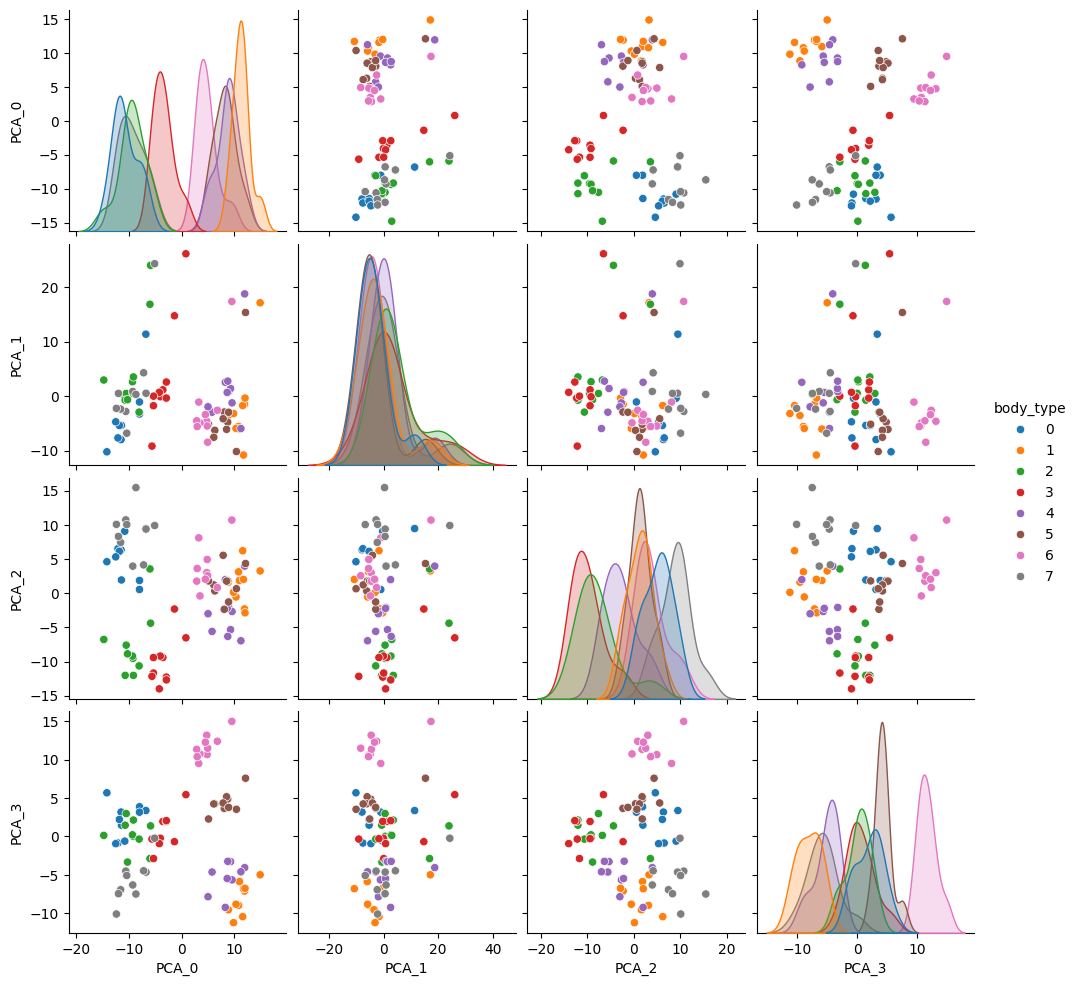

In [44]:
pca_df = pd.DataFrame(Cxy_T_Cxy_040_pca[:, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names_y[:80]

# assign one color to elements 0 - 9, second to 10 - 19, etc.
pca_df['body_type'] = [i // 10 for i in range(80)]

sns.pairplot(pca_df, diag_kind='kde',
             hue='body_type',
             palette='tab10')
plt.show()

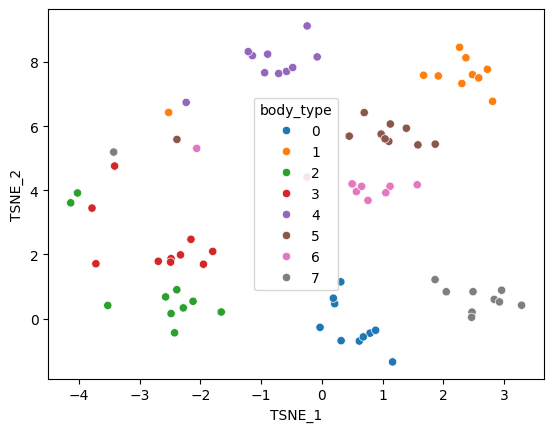

In [63]:
# repeat with T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
scaler = StandardScaler()

Cxy_T_Cxy_040_scaled = scaler.fit_transform(Cxy_T_Cxy_040[:, :20, :20].cpu().numpy().reshape(-1, 400))

Cxy_T_Cxy_040_tsne = tsne.fit_transform(
    Cxy_T_Cxy_040_scaled
    )

pca_df = pd.DataFrame(Cxy_T_Cxy_040_tsne, columns=['TSNE_1', 'TSNE_2'])
pca_df['name'] = names_y[:80]
pca_df['body_type'] = [i // 10 for i in range(80)]
# pca_df['pose'] = [i % 10 for i in range(80)]

sns.scatterplot(data=pca_df, x='TSNE_1', y='TSNE_2', hue='body_type', palette='tab10')
plt.show()


# Cxy for the entire dataset

In [87]:
# make color map based on name
names = [data['first']['name'] for data in train_dataset]
names_unique = np.unique(np.array(names))
colors = np.array([np.where(names_unique == name)[0][0] for name in names])

names_y = [data['second']['name'] for data in train_dataset]
colors_yx = np.array([np.where(names_unique == name)[0][0] for name in names_y])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6400/6400 [00:00<00:00, 444297.16it/s]


Cxy_full_pca.shape (6400, 20)


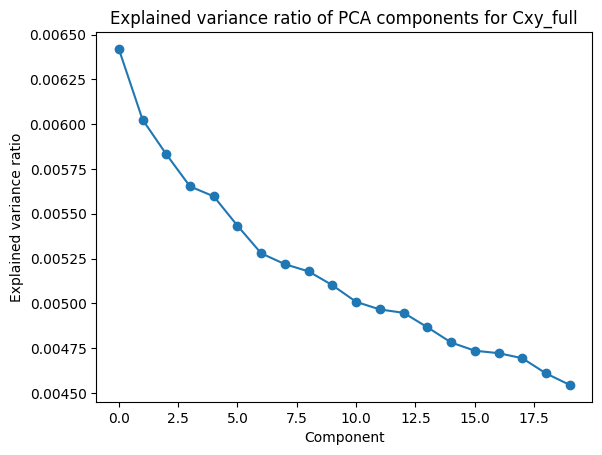

In [16]:
from sklearn.preprocessing import StandardScaler

Cxy_full = []
Cyx_full = []

for i in tqdm(range(len(train_dataset))):
    data = train_dataset[i]
    Cxy_full.append(data['Cxy'])
    Cyx_full.append(data['Cyx'])
    
Cxy_full = torch.stack(Cxy_full)[:, :20, :20]
Cyx_full = torch.stack(Cyx_full)[:, :20, :20]

pca_full = PCA(n_components=20)
scaler_full = StandardScaler()

Cxy_full_np = Cxy_full.cpu().numpy()

Cxy_full_scaled = scaler_full.fit_transform(Cxy_full_np.reshape(-1, 400))
Cxy_full_pca = pca_full.fit_transform(Cxy_full_scaled)

print('Cxy_full_pca.shape', Cxy_full_pca.shape)

plt.plot(pca_full.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_full')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

    

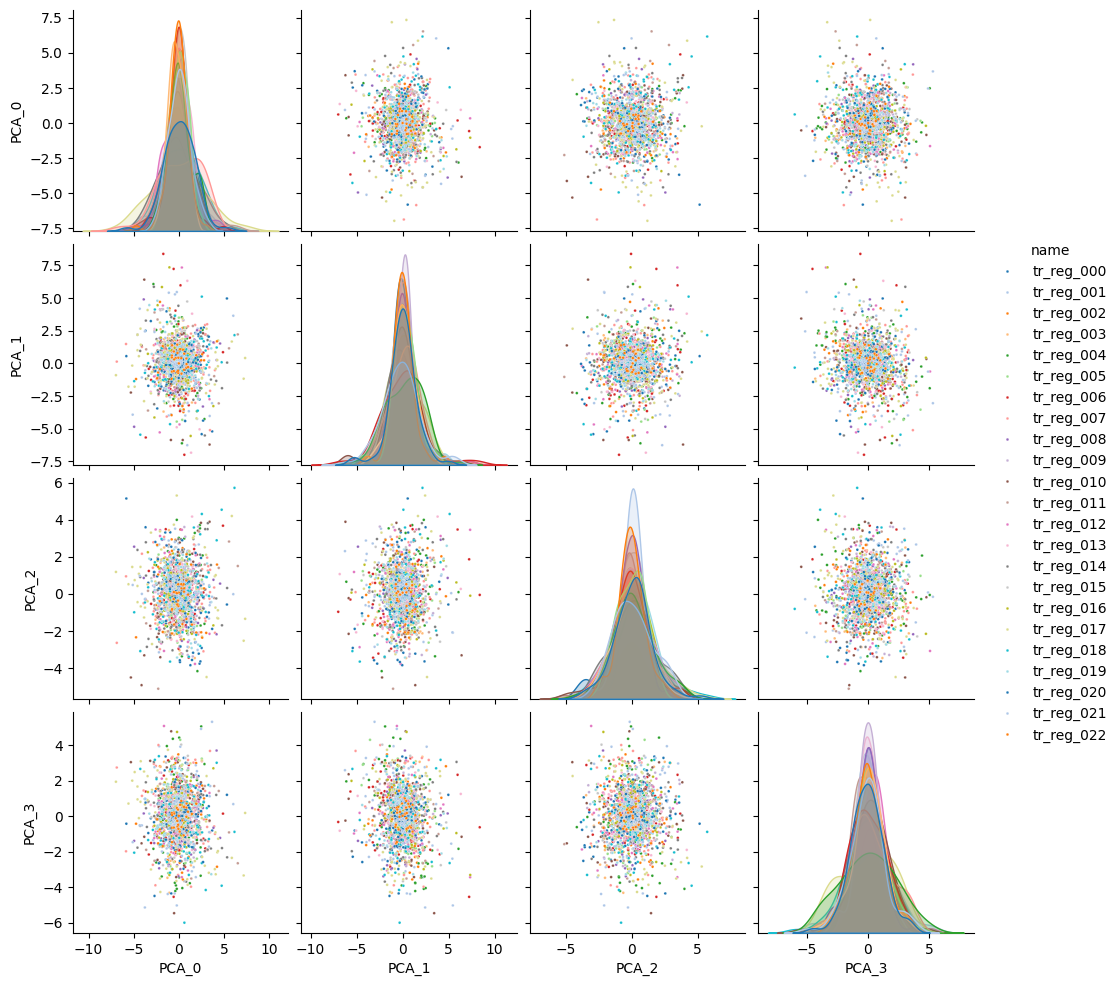

In [17]:
# plot the first 6 principal components
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(Cxy_full_pca[:1800, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names[:1800]

sns.pairplot(pca_df, diag_kind='kde',
             hue='name', palette='tab20',
             plot_kws={'s': 4, 'alpha': 1})
plt.show()

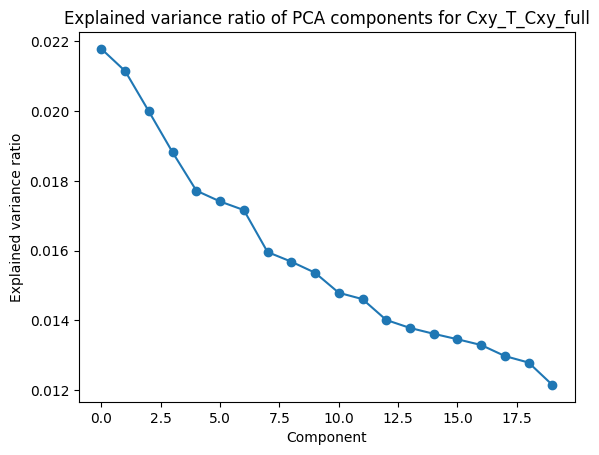

In [18]:
# import RobustScaler
from sklearn.preprocessing import RobustScaler

Cxy_T_Cxy_full = torch.bmm(Cxy_full.transpose(1, 2), Cxy_full)
Cxy_T_Cxy_full_np = Cxy_T_Cxy_full.cpu().numpy()

scaler = StandardScaler()
pca_full = PCA(n_components=20)

Cxy_T_Cxy_full_scaled = scaler.fit_transform(Cxy_T_Cxy_full_np[:, :20, :20].reshape(-1, 400))
# Cxy_T_Cxy_full_scaled = Cxy_T_Cxy_full_np[:, :20, :20].reshape(-1, 400)

Cxy_T_Cxy_full_pca = pca_full.fit_transform(Cxy_T_Cxy_full_scaled)

plt.plot(pca_full.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Cxy_T_Cxy_full')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')
plt.show()

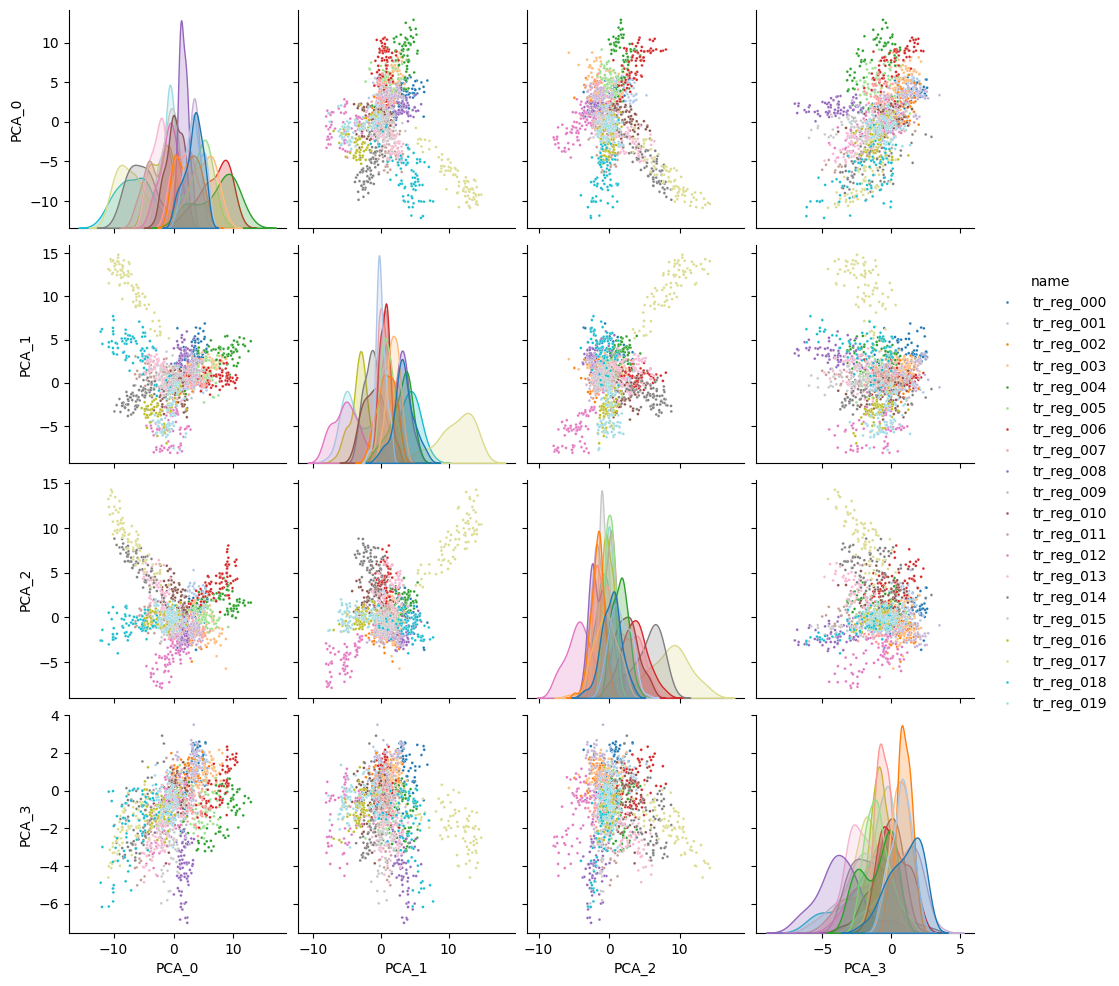

In [35]:
# plot the first 6 principal components
import seaborn as sns
import pandas as pd

pca_df = pd.DataFrame(Cxy_T_Cxy_full_pca[:1600, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names[:1600]

sns.pairplot(pca_df, diag_kind='kde',
             hue='name', palette='tab20',
             plot_kws={'s': 4, 'alpha': 1})
plt.show()

# Same with T-SNE

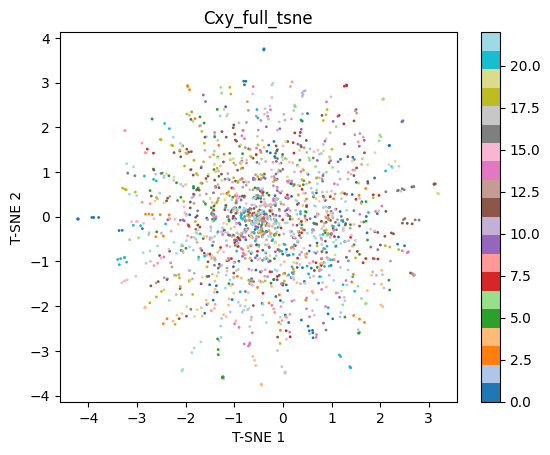

In [20]:
from sklearn.manifold import TSNE

tsne_full = TSNE(n_components=2)

Cxy_full_tsne = tsne_full.fit_transform(
    Cxy_full_scaled[:1800]
    )

plt.scatter(Cxy_full_tsne[:, 0], Cxy_full_tsne[:, 1], 
            alpha=1, c=colors[:1800], cmap='tab20', s=1)
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Cxy_full_tsne')
plt.colorbar()

plt.show()


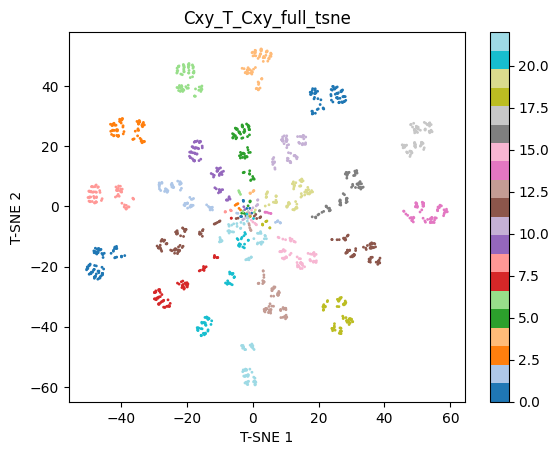

In [21]:
from sklearn.manifold import TSNE

tsne_full = TSNE(n_components=2)

Cxy_T_Cxy_full_tsne = tsne_full.fit_transform(
    Cxy_T_Cxy_full_scaled[:1800]
    )

plt.scatter(Cxy_T_Cxy_full_tsne[:, 0], Cxy_T_Cxy_full_tsne[:, 1], 
            alpha=1, c=colors[:1800], cmap='tab20', s=1, )
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Cxy_T_Cxy_full_tsne')
plt.colorbar()

plt.show()


Vortex in the middle probably corresponds to area preserving, but non-conformal mappings

# Conformal difference

In [71]:
names_y = []
Cxy_tr_reg_040 = []
Dx_40 = []
Dy_40 = []

train_dataset = train_loader.dataset
print(len(train_dataset))
for i in range(len(train_dataset)):
    data = train_dataset[i]
    if data['first']['name'] == 'tr_reg_040':
        Cxy_tr_reg_040.append(data['Cxy'])
        names_y.append(data['second']['name'])
        
        Dx_40.append(data['first']['evals'])
        Dy_40.append(data['second']['evals'])
        
        # Dy_40.append(data['first']['evals'])
        # Dx_40.append(data['second']['evals'])

Cxy_tr_reg_040_full = torch.stack(Cxy_tr_reg_040)
Cxy_tr_reg_040 = torch.stack(Cxy_tr_reg_040)[:, :20, :20]
    
Dx_40_full = torch.stack(Dx_40)
Dy_40_full = torch.stack(Dy_40)

print('Dx_40_full.shape', Dx_40_full.shape)
print('Dy_40_full.shape', Dy_40_full.shape)

Dx_40 = torch.stack(Dx_40)[:, :20]
Dy_40 = torch.stack(Dy_40)[:, :20]

# print('Dx_40', Dx_40.shape)
# print('Dy_40', Dy_40.shape)


# print('torch.diag(1 / Dx_40)', torch.diag_embed(1 / Dx_40).shape, torch.diag_embed(1 / Dx_40))

Rmn_40_left = torch.bmm(torch.diag_embed(1 / Dx_40), Cxy_tr_reg_040.transpose(1, 2))
Rmn_40_right = torch.bmm(torch.diag_embed(Dy_40), Cxy_tr_reg_040)

# print('Rmn_left.shape', Rmn_40_left.shape)
# print('Rmn_right.shape', Rmn_40_right.shape)

Rmn_40 = torch.bmm(Rmn_40_left, Rmn_40_right)
# print('Rmn.shape', Rmn_40.shape)

6400
Dx_40_full.shape torch.Size([80, 200])
Dy_40_full.shape torch.Size([80, 200])


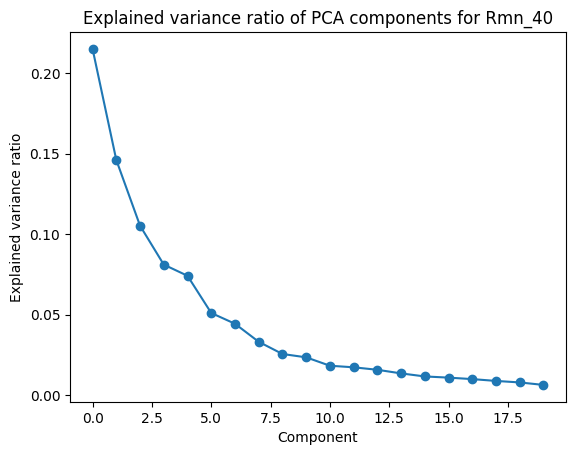

In [72]:
pca = PCA(n_components=20)

scaler = StandardScaler()

Rmn_40_scaled = scaler.fit_transform(Rmn_40[:, :20, :20].cpu().numpy().reshape(-1, 400))

Rmn_40_pca = pca.fit_transform(
    Rmn_40_scaled
    )


plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Rmn_40')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

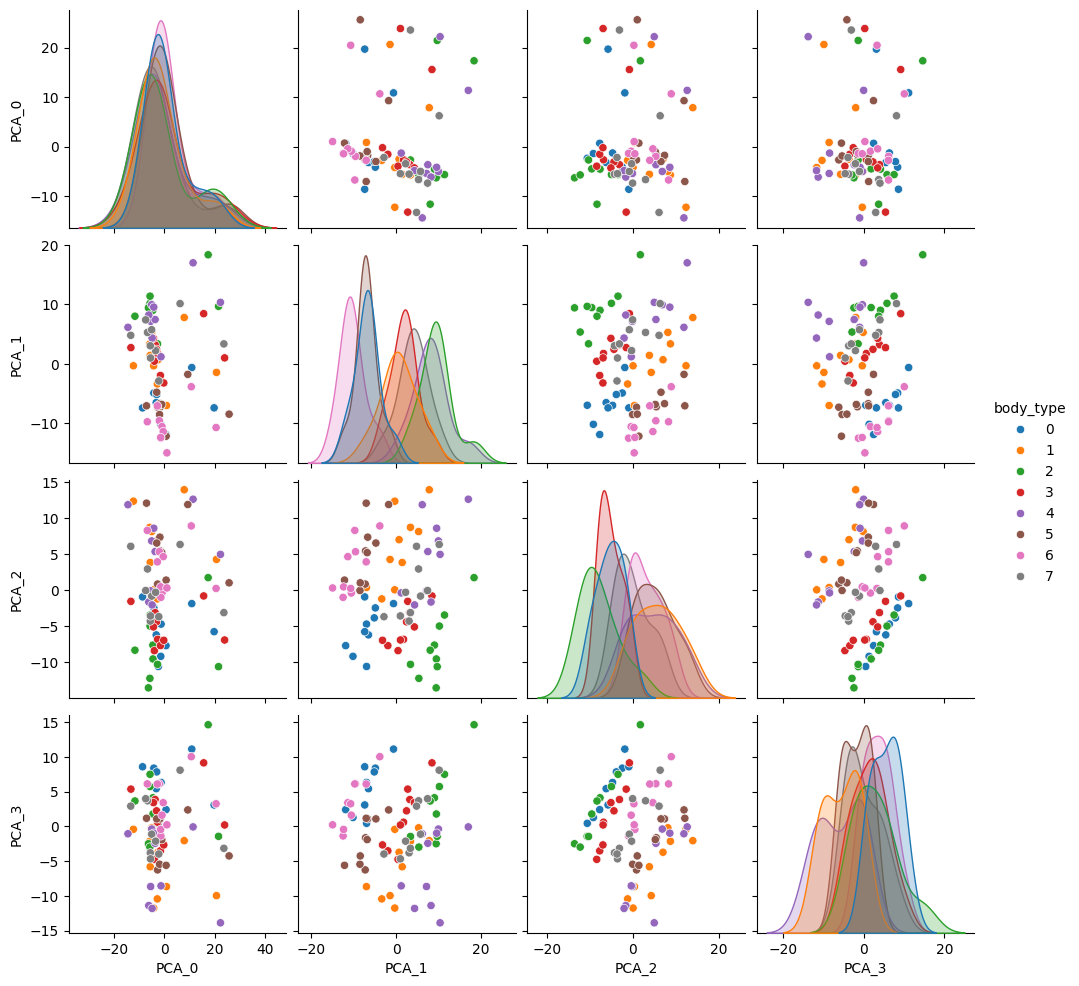

In [73]:
pca_df = pd.DataFrame(Rmn_40_pca[:, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names_y[:80]

# assign one color to elements 0 - 9, second to 10 - 19, etc.
pca_df['body_type'] = [i // 10 for i in range(80)]
# pca_df['pose'] = [i % 10 for i in range(80)]

sns.pairplot(pca_df, diag_kind='kde',
             hue='body_type',
             palette='tab10')
plt.show()

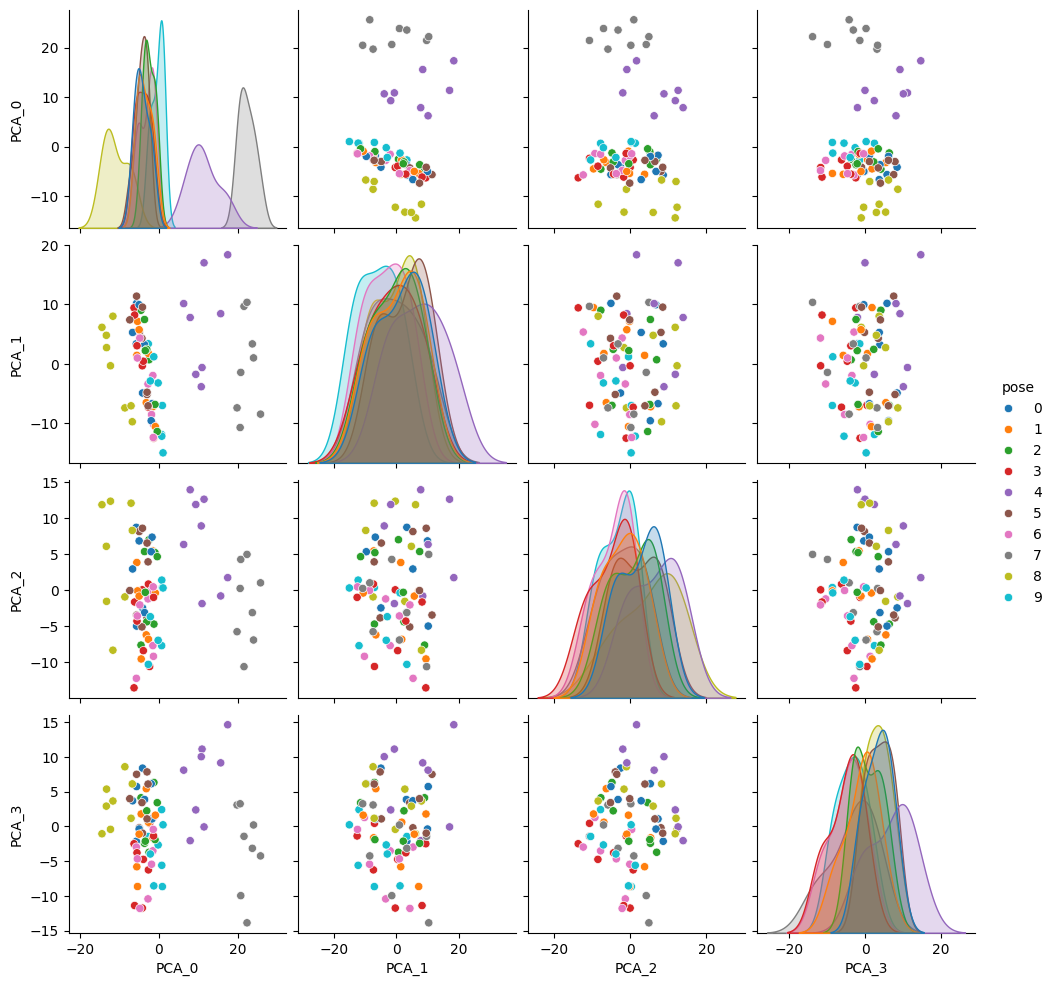

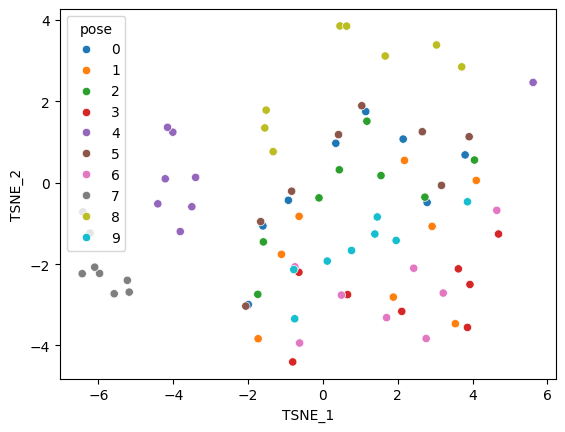

In [75]:
# repeat with T-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
scaler = StandardScaler()

Rmn_40_scaled = scaler.fit_transform(Rmn_40[:, :20, :20].cpu().numpy().reshape(-1, 400))

Rmn_40_tsne = tsne.fit_transform(
    Rmn_40_scaled
    )

pca_df = pd.DataFrame(Rmn_40_tsne, columns=['TSNE_1', 'TSNE_2'])
pca_df['name'] = names_y[:80]
# pca_df['body_type'] = [i // 10 for i in range(80)]
pca_df['pose'] = [i % 10 for i in range(80)]

sns.scatterplot(data=pca_df, x='TSNE_1', y='TSNE_2', hue='pose', palette='tab10')
plt.show()


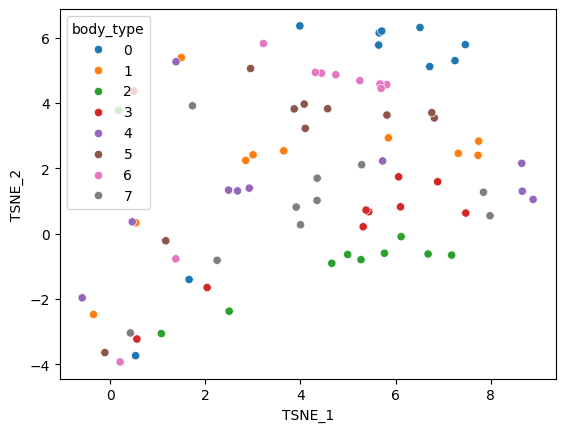

# Full dataset

In [78]:
names_y = []
Cxy_full = []
Dx_full = []
Dy_full = []

train_dataset = train_loader.dataset
print(len(train_dataset))
for i in range(len(train_dataset)):
    data = train_dataset[i]
    Cxy_full.append(data['Cxy'])
    names_y.append(data['second']['name'])
    
    Dx_full.append(data['first']['evals'])
    Dy_full.append(data['second']['evals'])
        
        # Dy_40.append(data['first']['evals'])
        # Dx_40.append(data['second']['evals'])

# Cxy_full = torch.stack(Cxy_tr_reg_040)
Cxy_full = torch.stack(Cxy_full)[:, :20, :20]
    
# Dx_full = torch.stack(Dx_full)
# Dy_full = torch.stack(Dy_full)

# print('Dx_full.shape', Dx_full.shape)
# print('Dy_full.shape', Dy_full.shape)

Dx_full = torch.stack(Dx_full)[:, :20]
Dy_full = torch.stack(Dy_full)[:, :20]

# print('Dx_40', Dx_40.shape)
# print('Dy_40', Dy_40.shape)


# print('torch.diag(1 / Dx_40)', torch.diag_embed(1 / Dx_40).shape, torch.diag_embed(1 / Dx_40))

Rmn_full_left = torch.bmm(torch.diag_embed(1 / Dx_full), Cxy_full.transpose(1, 2))
Rmn_full_right = torch.bmm(torch.diag_embed(Dy_full), Cxy_full)

# print('Rmn_left.shape', Rmn_40_left.shape)
# print('Rmn_right.shape', Rmn_40_right.shape)

Rmn_full = torch.bmm(Rmn_full_left, Rmn_full_right)
# print('Rmn.shape', Rmn_40.shape)

6400


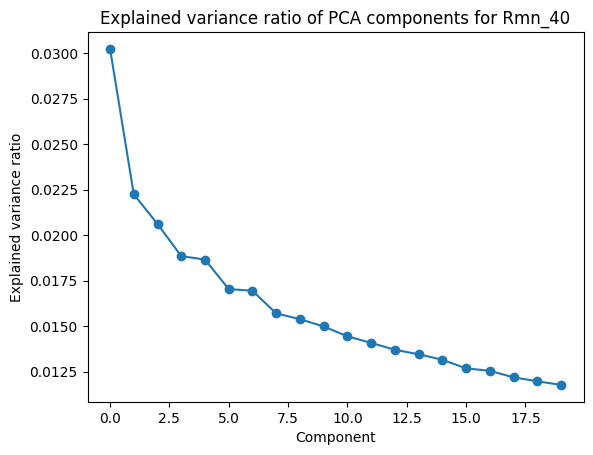

In [79]:
pca = PCA(n_components=20)

scaler = StandardScaler()

Rmn_full_scaled = scaler.fit_transform(Rmn_full[:, :20, :20].cpu().numpy().reshape(-1, 400))

Rmn_full_pca = pca.fit_transform(
    Rmn_full_scaled
    )


plt.plot(pca.explained_variance_ratio_, 'o-')
plt.title('Explained variance ratio of PCA components for Rmn_40')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

plt.show()

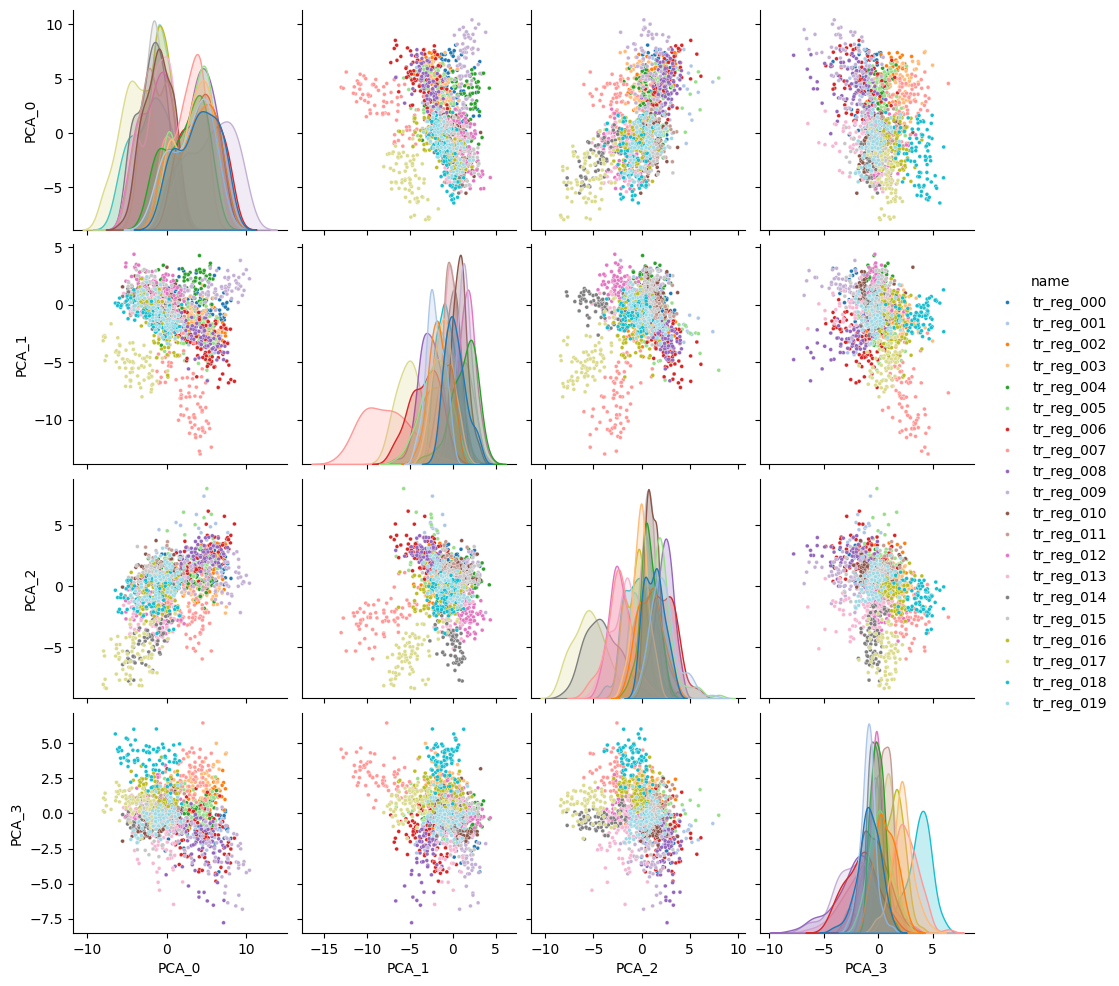

In [84]:
pca_df = pd.DataFrame(Rmn_full_pca[:1600, :4], columns=[f'PCA_{i}' for i in range(4)])
pca_df['name'] = names[:1600]

# assign one color to elements 0 - 9, second to 10 - 19, etc.
# pca_df['body_type'] = [i // 10 for i in range(80)]
# pca_df['pose'] = [i % 10 for i in range(80)]

sns.pairplot(pca_df, diag_kind='kde',
             hue='name',
             palette='tab20', plot_kws={'s': 8, 'alpha': 1})
plt.show()

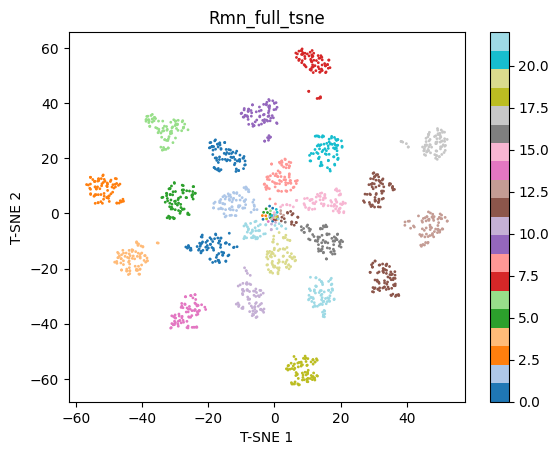

In [89]:
from sklearn.manifold import TSNE

tsne_full = TSNE(n_components=2)

Rmn_full_tsne = tsne_full.fit_transform(
    Rmn_full_scaled[:1800]
    )

plt.scatter(Rmn_full_tsne[:, 0], Rmn_full_tsne[:, 1], 
            alpha=1, c=colors[:1800], cmap='tab20', s=1, )
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.title('Rmn_full_tsne')
plt.colorbar()

plt.show()
